<a href="https://colab.research.google.com/github/WilliamShengYangHuang/AALU_Workshop_3/blob/main/exporting_latent_codes_pca_t_sne_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
"""import json
from keras.utils.data_utils import get_file
from keras import backend as K

CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'


def preprocess_input(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.set_image_data_format('channels_first')
    assert dim_ordering in {'tf', 'th'}

    if dim_ordering == 'th':
        x[:, 0, :, :] -= 103.939
        x[:, 1, :, :] -= 116.779
        x[:, 2, :, :] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x


def decode_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results"""

"import json\nfrom keras.utils.data_utils import get_file\nfrom keras import backend as K\n\nCLASS_INDEX = None\nCLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'\n\n\ndef preprocess_input(x, dim_ordering='default'):\n    if dim_ordering == 'default':\n        dim_ordering = K.set_image_data_format('channels_first')\n    assert dim_ordering in {'tf', 'th'}\n\n    if dim_ordering == 'th':\n        x[:, 0, :, :] -= 103.939\n        x[:, 1, :, :] -= 116.779\n        x[:, 2, :, :] -= 123.68\n        # 'RGB'->'BGR'\n        x = x[:, ::-1, :, :]\n    else:\n        x[:, :, :, 0] -= 103.939\n        x[:, :, :, 1] -= 116.779\n        x[:, :, :, 2] -= 123.68\n        # 'RGB'->'BGR'\n        x = x[:, :, :, ::-1]\n    return x\n\n\ndef decode_predictions(preds, top=5):\n    global CLASS_INDEX\n    if len(preds.shape) != 2 or preds.shape[1] != 1000:\n        raise ValueError('`decode_predictions` expects '\n                         'a batch o

## Import Packages

In [2]:
import skimage
import cv2 as cv
import os
import numpy as np
from sklearn import manifold, datasets
import pickle as pkl

import keras
from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg19 import VGG19
from skimage.transform import resize
#import imagenet_utils as imu
from keras.applications import imagenet_utils as imu

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from sklearn import manifold, datasets
import time

import matplotlib.pyplot as plt
import sklearn.decomposition as dp
import imageio
from skimage import io,transform,color
from skimage import img_as_ubyte
#from sklearn.datasets.base import load_iris
from PIL import Image

from glob import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [3]:
PATH = '/content/drive/My Drive/frame_captures/' #@param{type:'string'}

#images = [cv.imread(file, cv.COLOR_BGR2RGB) for file in glob(PATH + '/*.jpg')]
#print(len(images))

In [4]:
#@title
"""rootfolder = PATH
file_list = os.listdir(rootfolder)
print(file_list)"""

'rootfolder = PATH\nfile_list = os.listdir(rootfolder)\nprint(file_list)'

In [5]:
#@title
"""file_list_sorted = file_list.sort()
print(file_list_sorted)"""

'file_list_sorted = file_list.sort()\nprint(file_list_sorted)'

In [6]:
#@title
"""
#rootfolder = 'D:\\COMPUTER_VISION\\AAPR\\10000_imgs_aa_barrel_vault'
file_list = []
for i in range(len(os.listdir(rootfolder))):
  file_list.append(plt.imread(PATH + str(i+10000) + '.jpg'))

print(file_list)"""

"\n#rootfolder = 'D:\\COMPUTER_VISION\\AAPR\\10000_imgs_aa_barrel_vault'\nfile_list = []\nfor i in range(len(os.listdir(rootfolder))):\n  file_list.append(plt.imread(PATH + str(i+10000) + '.jpg'))\n\nprint(file_list)"

In [7]:
#np.array(file_list)

### Preview

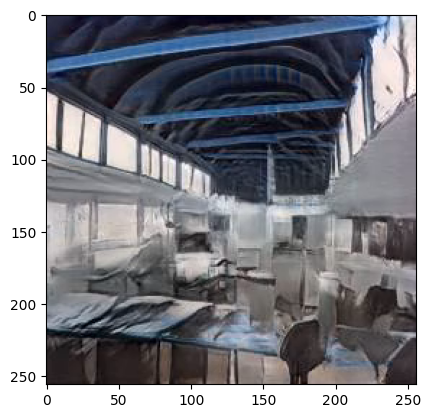

In [8]:
# Initialise the image stack with the first image
img = cv.imread(PATH + '0000.jpg') # Mind the naming pattern
#print(img)
plt.imshow(img)

## PCA (principal component analysis)

In [9]:
num_imgs = 60 #@param{type:'integer'}

In [10]:
# Initialise im_stack as an empty list
im_stack = []

In [11]:
target_size = 256 #@param{type:'integer'}

# Process each image
for i in range(1, num_imgs + 1):
    # Generate file name in four-digit format (e.g., 0001.jpg)
    img_path = os.path.join(PATH, f"{i:04}.jpg")
    img = cv.imread(img_path)

    if img is None:
        print(f"Image {i:04}.jpg could not be loaded.")
        continue  # Skip this image if it cannot be loaded

    try:
        # Convert to grayscale
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Resize the image
        new_size = (target_size, target_size)
        img_gray = cv.resize(img_gray, new_size, interpolation=cv.INTER_AREA)

        # Flatten the image and append to the stack
        im_stack.append(img_gray.flatten())

    except Exception as e:
        print(f"Error processing image {i:04}.jpg: {e}")

# Convert im_stack to a NumPy array after all processing is complete
im_stack = np.array(im_stack)

# Check if im_stack is empty
if im_stack.size == 0:
    print("No valid images were processed. Please check the image files.")
else:
    print(f"Processed image stack shape: {im_stack.shape}")

    # Verify the flattened size of images
    expected_size = target_size * target_size
    assert im_stack.shape[1] == expected_size, \
        "The flattened image size does not match the expected dimensions."

    # Function to perform PCA on the image stack
    def PCA(matrix, num_components=3):
        pca = dp.PCA(n_components=num_components)
        pca_features = pca.fit_transform(matrix)
        return pca_features

    # Apply PCA to the image stack
    low_matrix = PCA(im_stack)

    # Display the PCA features for each image
    for i, features in enumerate(low_matrix):
        print(f"Image {i+1:04} PCA features: {features}")

Image 0060.jpg could not be loaded.
Processed image stack shape: (59, 65536)
Image 0001 PCA features: [-4710.01305264  2832.50056615  5022.59727477]
Image 0002 PCA features: [-6734.58554123   215.32423542  4773.6510623 ]
Image 0003 PCA features: [-10946.51608362   -291.6770387    3950.09750504]
Image 0004 PCA features: [-13292.62568205    124.49635362   1800.12550949]
Image 0005 PCA features: [-11926.96868619    971.37842278   1052.53515777]
Image 0006 PCA features: [-10224.90958681   1511.7818947     259.52490025]
Image 0007 PCA features: [-5320.0622111   -606.64819673 -4589.05931088]
Image 0008 PCA features: [ 5532.57689293 -7578.38289337 -7032.42910947]
Image 0009 PCA features: [ 7819.96404219 -5323.09373448 -5706.43457084]
Image 0010 PCA features: [ 7051.14432613 -5161.78459886 -2934.13238151]
Image 0011 PCA features: [ 6254.96057597 -5098.05823727 -1311.49759307]
Image 0012 PCA features: [ 5348.32805839 -5226.20271565  -621.57853673]
Image 0013 PCA features: [ 5338.73226689 -5243.

In [12]:
"""
def PCA(matrix, num_components=3):
    # Load the PCA algorithm, set the principal component after dimensionality reduction to num_components
    pca = dp.PCA(n_components=num_components)
    # Dimensionality reduction on raw data
    pca_features = pca.fit_transform(matrix)

    # Print the first two PCA features for brevity
    print(pca_features[0])
    print(pca_features[1])

    # Print PCA features for each image
    for i in range(num_imgs):
        print(f"Image {i+1} PCA features: {pca_features[i]}")

    return pca_features

# Apply PCA to the image stack
low_matrix = PCA(im_stack)
"""

'\ndef PCA(matrix, num_components=3):\n    # Load the PCA algorithm, set the principal component after dimensionality reduction to num_components\n    pca = dp.PCA(n_components=num_components)\n    # Dimensionality reduction on raw data\n    pca_features = pca.fit_transform(matrix)\n\n    # Print the first two PCA features for brevity\n    print(pca_features[0])\n    print(pca_features[1])\n\n    # Print PCA features for each image\n    for i in range(num_imgs):\n        print(f"Image {i+1} PCA features: {pca_features[i]}")\n\n    return pca_features\n\n# Apply PCA to the image stack\nlow_matrix = PCA(im_stack)\n'

## T-SNE (t-distributed stochastic neighbor embedding)

In [14]:
# Parameters for t-SNE
_n_dim = 3
_perplexity = 10
_learning_rate = 100
_scale = 1

# Apply t-SNE
tsne = manifold.TSNE(
    n_components=_n_dim,
    init='pca',
    random_state=0,
    perplexity=int(_perplexity),
    learning_rate=int(_learning_rate)
)
X_tsne = tsne.fit_transform(low_matrix)  # Fit and transform data
X_tsne = X_tsne * _scale  # Scale the transformed data
output = X_tsne.tolist()  # Convert to list

# Debug: Check lengths
print(f"Number of images processed: {len(output)}")

# Output results
for i in range(len(output)):  # Loop through the actual size of output
    print(f"Image {i + 1}: {output[i]}")


Number of images processed: 59
Image 1: [11.51823616027832, 0.547709047794342, -3.3367652893066406]
Image 2: [53.31751251220703, -10.17300796508789, -10.813325881958008]
Image 3: [92.01588439941406, 18.711458206176758, -15.729981422424316]
Image 4: [97.51680755615234, 67.01615905761719, -36.42189407348633]
Image 5: [99.59014892578125, 57.80085754394531, 6.556937217712402]
Image 6: [132.8668975830078, 43.62290573120117, -14.986130714416504]
Image 7: [-48.202919006347656, 78.43285369873047, -44.23965835571289]
Image 8: [-99.82305145263672, -4.8623223304748535, -12.372929573059082]
Image 9: [-33.974334716796875, 2.709890127182007, 118.30355834960938]
Image 10: [-58.60098648071289, -27.798982620239258, -25.386032104492188]
Image 11: [-83.28751373291016, -60.69945526123047, -42.25849914550781]
Image 12: [-66.36546325683594, -68.99252319335938, -6.838757514953613]
Image 13: [-8.469282150268555, -81.09137725830078, 22.267173767089844]
Image 14: [30.455358505249023, -73.96913146972656, 68.9761

### Simple Visualisation

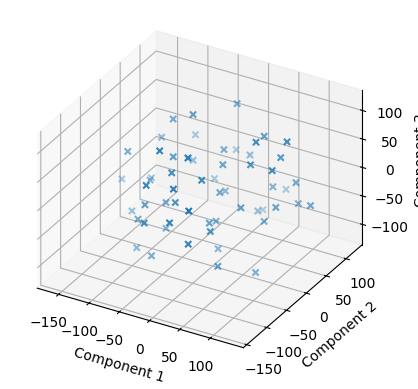

In [15]:
# Plotting the results in a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot without perspective (orthographic projection)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], marker = 'x')
ax.set_proj_type('ortho')  # Setting orthographic projection

# Labeling axes
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Show the plot
plt.show()


[0.00107616 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616
 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616
 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616
 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616
 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616
 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616
 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616
 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616
 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616
 0.00107616 0.00107616 0.00107616 0.00107616 0.00107616]


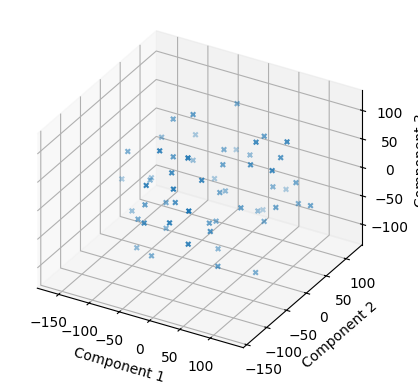

In [16]:
from sklearn.neighbors import KernelDensity
from mpl_toolkits.mplot3d import Axes3D

# Compute kernel density estimates for each point in the t-SNE data
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(X_tsne)
densities = kde.score_samples(X_tsne)  # Log density
densities = np.exp(densities)  # Convert log density to actual density
print(densities)

# Scale densities for marker sizes in the plot
density_scale = 10**4  # Scale factor for better visualisation
marker_sizes = densities * density_scale

# Creating the 3D scatter plot with marker sizes based on local kernel density
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot without perspective, marker sizes based on density
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], marker='x', s=marker_sizes)

# Setting orthographic projection
ax.set_proj_type('ortho')

# Labeling axes
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Show the plot
plt.show()

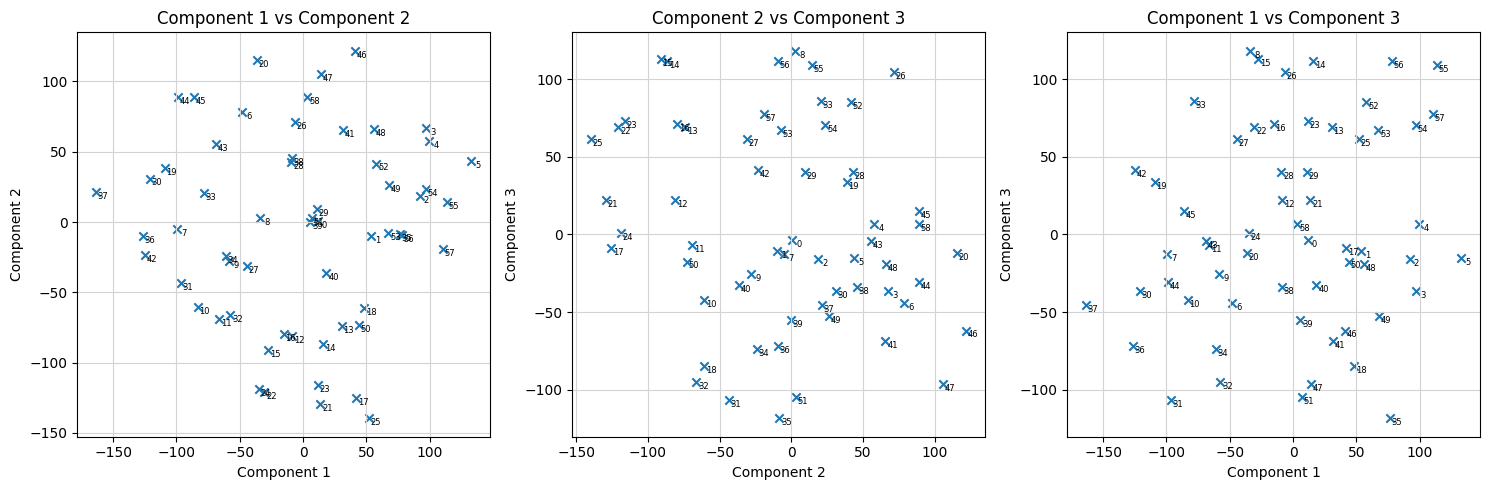

In [17]:
# Adjusting the annotation font size and adding gridlines to the scatter plots

# Re-creating the subplots with smaller font size for annotations and added gridlines
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define a function for plotting and annotating with smaller font and gridlines
def plot_and_annotate(ax, x_data, y_data, title, xlabel, ylabel):
    ax.scatter(x_data, y_data, marker = 'x')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, color = 'lightgrey')  # Adding gridlines
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        ax.annotate(i, (x, y), textcoords="offset points", xytext=(5,-5), ha='center', fontsize=6)  # Smaller font size

# Component 1 vs Component 2 with annotations
plot_and_annotate(axs[0], X_tsne[:, 0], X_tsne[:, 1], 'Component 1 vs Component 2', 'Component 1', 'Component 2')

# Component 2 vs Component 3 with annotations
plot_and_annotate(axs[1], X_tsne[:, 1], X_tsne[:, 2], 'Component 2 vs Component 3', 'Component 2', 'Component 3')

# Component 1 vs Component 3 with annotations
plot_and_annotate(axs[2], X_tsne[:, 0], X_tsne[:, 2], 'Component 1 vs Component 3', 'Component 1', 'Component 3')

# Display the annotated plots
plt.tight_layout()
plt.show()


[19.28219175 19.78634148 19.58168051 12.12756416 13.84275398  9.75094431
 11.99435449 14.73618852 16.32646752 17.26972278 13.906175   14.99282218
 18.29780436 16.52784174 17.8407012  16.97753501 18.07594389 11.2158853
 14.43009935 11.68545275  7.78603964 12.99037133 12.55396246 15.51735143
 12.28692956  7.86711594 14.94423303 17.28075187 16.63101775 19.32423606
 11.20804758 13.93069277 16.14810339 13.89462559 17.11660748 19.22791356
 11.71571031  5.96083077 16.48579049 18.98439295 17.3435461  15.46258607
 11.27285463 12.40045377  8.12232523  9.2172618   6.7424036  10.74707484
 14.65430822 20.48614298 14.63130485 19.11406154 18.52456374 19.86491813
 18.76931078 15.31739325 18.954842   11.70685387 13.29100452]
[23.36293919 22.77179808 26.88625599 24.88071354 23.56074288 27.80374889
 21.53216805 23.72837781 12.63709483 21.03921518 15.36387538 15.30684649
 13.29472521 13.82124133  9.58500897  9.25771217 13.77818801  9.26652601
 11.89987411 20.18461611 11.72017879 10.81320245 11.9573872  12

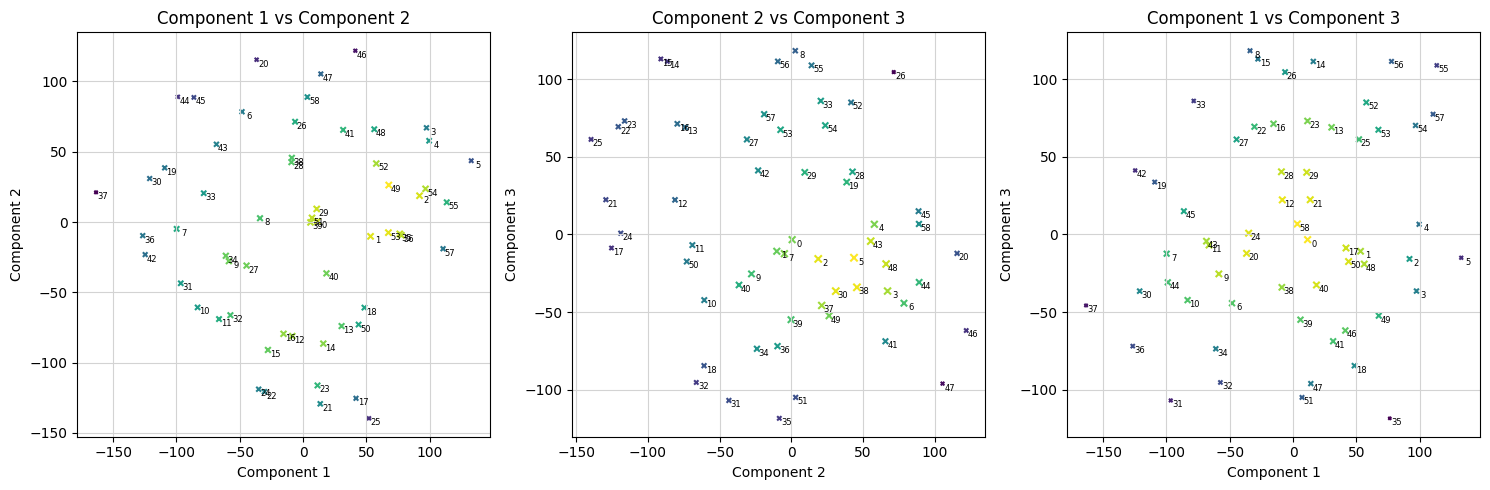

In [18]:
from scipy.stats import gaussian_kde

# Re-creating the subplots with density-based marker sizes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define a function for plotting and annotating with density-based marker sizes
def plot_and_annotate(ax, x_data, y_data, title, xlabel, ylabel):
    # Calculating the point density
    xy = np.vstack([x_data, y_data])
    scale = 10**6
    z = gaussian_kde(xy)(xy)*scale

    # Scatter plot with density-based marker sizes
    ax.scatter(x_data, y_data, s=z, marker='x', c=z)  # Scaling marker size by density
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, color='lightgrey')  # Adding gridlines
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        ax.annotate(i, (x, y), textcoords="offset points", xytext=(5,-5), ha='center', fontsize=6)  # Smaller font size
    print(z)

# Component 1 vs Component 2 with density-based marker sizes
plot_and_annotate(axs[0], X_tsne[:, 0], X_tsne[:, 1], 'Component 1 vs Component 2', 'Component 1', 'Component 2')

# Component 2 vs Component 3 with density-based marker sizes
plot_and_annotate(axs[1], X_tsne[:, 1], X_tsne[:, 2], 'Component 2 vs Component 3', 'Component 2', 'Component 3')

# Component 1 vs Component 3 with density-based marker sizes
plot_and_annotate(axs[2], X_tsne[:, 0], X_tsne[:, 2], 'Component 1 vs Component 3', 'Component 1', 'Component 3')

# Display the annotated plots
plt.tight_layout()
plt.show()


## Save CSV

In [ ]:
# Convert the list to an array
my_array = np.array(output)

# Save the array as a CSV file
f_name = 'Latent_codes_30-nov' #@param{type:'string'}
np.savetxt(f_name + '.csv', my_array, delimiter=',')

## Save Model

In [ ]:
"""
from pathlib import Path
features = np.stack(low_matrix, axis=0)

# rootfolder2 = Path + '_features'
rootfolder2 = '/content/drive/My Drive/'
fileName = os.path.join(rootfolder2,'pca_pool')
fileObject = open(fileName, 'wb')
pkl.dump(features, fileObject)
fileObject.close()
"""